## Petrophysical properties inversion from seismic data

In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
from random import randint
from wiggle.wiggle import wiggle
from matplotlib.pyplot import figure
import math
import tensorflow as tf

In [2]:
# Checking the devices available for use in AWS
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7485593971058679373
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12303736041706160612
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 610156470938973378
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11326753997
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1360319963426605091
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [3]:
# Loading the Vp, Vs and Density data

dataframe = sio.loadmat('../../../Data_generation_base_case/Train_DataSyn1_time_clip.mat')
Vp = dataframe['VpMat']
Vp = np.reshape(Vp, (Vp.shape[0]*Vp.shape[1], Vp.shape[2]))
Vs = dataframe['VsMat']
Vs = np.reshape(Vs, (Vs.shape[0]*Vs.shape[1], Vs.shape[2]))
RHOB = dataframe['RHOBMat']
RHOB = np.reshape(RHOB, (RHOB.shape[0]*RHOB.shape[1], RHOB.shape[2]))

depth = dataframe['depthVec']

# Loading facies, porosity, vclay and water saturation data 
dataframe_facies = sio.loadmat('../../../Data_generation_base_case/Train_FaciesMat.mat')
facies = dataframe_facies['zFaciesMat']
facies = np.reshape(facies, (facies.shape[0]*facies.shape[1], facies.shape[2]))

dataframe_porosity = sio.loadmat('../../../Data_generation_base_case/Train_PhiMat.mat')
porosity = dataframe_porosity['zPhiMat']
porosity = np.reshape(porosity, (porosity.shape[0]*porosity.shape[1], porosity.shape[2]))

dataframe_vclay = sio.loadmat('../../../Data_generation_base_case/Train_ClayMat.mat')
vclay = dataframe_vclay['zClayMat']
vclay = np.reshape(vclay, (vclay.shape[0]*vclay.shape[1], vclay.shape[2]))

dataframe_Sw = sio.loadmat('../../../Data_generation_base_case/Train_SwMat.mat')
Sw = dataframe_Sw['zSwMat']
Sw = np.reshape(Sw, (Sw.shape[0]*Sw.shape[1], Sw.shape[2]))


Text(0.5,0,'Ip')

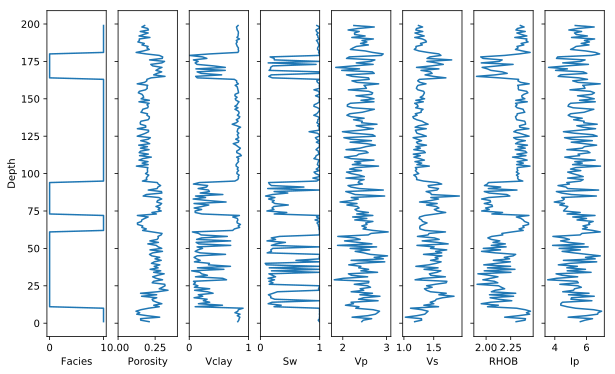

In [4]:
# Plot of loaded data

sample_number = 12
f, axarr = plt.subplots(1, 8, sharey = True, figsize=(10,6))

axarr[0].plot(facies[sample_number, :], depth)
axarr[0].set_xlabel("Facies")
axarr[0].set_ylabel("Depth")

axarr[1].plot(porosity[sample_number, :], depth)
axarr[1].set_xlabel("Porosity")
axarr[1].set_xlim(0,0.4)

axarr[2].plot(vclay[sample_number, :], depth)
axarr[2].set_xlabel("Vclay")
axarr[2].set_xlim(0,1)

axarr[3].plot(Sw[sample_number, :], depth)
axarr[3].set_xlabel("Sw")
axarr[3].set_xlim(0,1)

axarr[4].plot(Vp[sample_number, :], depth)
axarr[4].set_xlabel("Vp")
# plt.xlim(0,1)

axarr[5].plot(Vs[sample_number, :], depth)
axarr[5].set_xlabel("Vs")
# plt.xlim(0,1)

axarr[6].plot(RHOB[sample_number, :], depth)
axarr[6].set_xlabel("RHOB")
# plt.xlim(0,1)

axarr[7].plot(Vp[sample_number, :]*RHOB[sample_number, :], depth)
axarr[7].set_xlabel("Ip")

Text(0.5,0,'Vp/Vs')

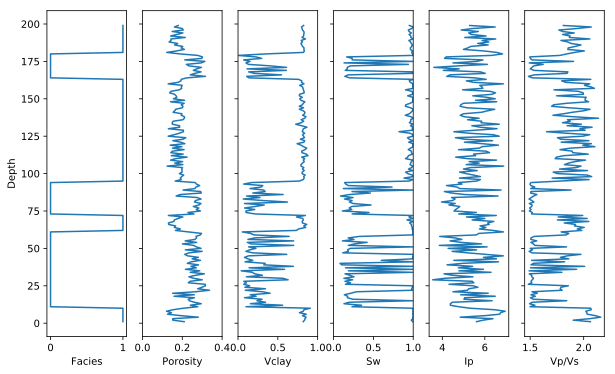

In [5]:
sample_number = 12
f, axarr = plt.subplots(1, 6, sharey = True, figsize=(10,6))

axarr[0].plot(facies[sample_number, :], depth)
axarr[0].set_xlabel("Facies")
axarr[0].set_ylabel("Depth")

axarr[1].plot(porosity[sample_number, :], depth)
axarr[1].set_xlabel("Porosity")
axarr[1].set_xlim(0,0.4)

axarr[2].plot(vclay[sample_number, :], depth)
axarr[2].set_xlabel("Vclay")
axarr[2].set_xlim(0,1)

axarr[3].plot(Sw[sample_number, :], depth)
axarr[3].set_xlabel("Sw")
axarr[3].set_xlim(0,1)

axarr[4].plot(Vp[sample_number, :]*RHOB[sample_number, :], depth)
axarr[4].set_xlabel("Ip")

axarr[5].plot(Vp[sample_number, :]/Vs[sample_number, :], depth)
axarr[5].set_xlabel("Vp/Vs")

In [4]:
# AVO and source parameters 
src_len=np.int(60)
freq=40
dt=7e-4
# ntheta=46
thetaStart=0
thetaEnd=30
thetaInc=5
theta=np.arange(thetaStart,thetaEnd+thetaInc,thetaInc)
ntheta=theta.size
# nt=201
# ncdp=1111
angle=np.reshape(theta,[1,ntheta])
# theta=np.arange(0,ntheta,1)
print('angle:', angle.shape)
print('angle:', angle)

angle: (1, 7)
angle: [[ 0  5 10 15 20 25 30]]


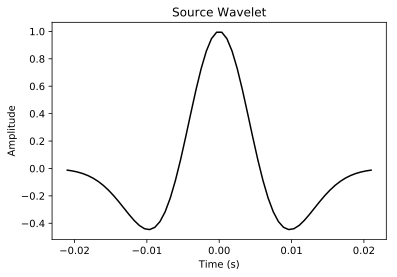

In [5]:
# Generate the seismic wavelet
def ricker(f,n,dt,t0):

    T = dt*(np.floor(n/2));
    t = np.linspace(-T,T,n)
    tau = t-t0;
    pi=np.pi
    s = (1-2*tau*tau*f**2*pi**2)*np.exp(-tau**2*pi**2*f**2);
    rw = s;

    return rw,t
src,tsrc=ricker(freq,src_len,dt,0)
plt.plot(tsrc,src, '-k')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Source Wavelet")
plt.show()

In [7]:
# Full Zoeppritz using tensorflow

def gather(input1,tftheta,tfsrc):
    print('input1:',input1)
    vp = tf.expand_dims(input1[:,:,0],2)
    vs = tf.expand_dims(input1[:,:,1],2)
    rho = tf.expand_dims(input1[:,:,2],2)
    vp=tf.check_numerics(vp,"Nan at vp start")
    vs=tf.check_numerics(vs,"Nan at vp start")
    rho=tf.check_numerics(rho,"Nan at vp start")
    

    nref= tf.shape(input1)[1]#vp.get_shape()[1]#.as_list()[1]
    bs=tf.shape(input1)[0]
    ntheta=tf.shape(tftheta)[1]
    #nt=tf.shape(input1)[1]
    
    tfzero=tf.zeros([bs,1,ntheta], dtype=tf.float32)
    
    tfangle = tf.expand_dims(tf.convert_to_tensor(tftheta, 
                                                  dtype=tf.float32),0)
    tfangle=tf.tile(tfangle,[bs,nref-1,1])

  
    vp1=tf.tile(vp[:,0:nref-1],[1, 1, ntheta])
    vs1=tf.tile(vs[:,0:nref-1],[1, 1, ntheta])
    d1=tf.tile(rho[:,0:nref-1],[1, 1, ntheta])

    vp2=tf.tile(vp[:,1:nref],[1, 1, ntheta])
    vs2=tf.tile(vs[:,1:nref],[1, 1, ntheta])
    d2=tf.tile(rho[:,1:nref],[1, 1, ntheta])
    
    
    vpj1=tf.complex(vp1,tf.zeros_like(vp1))
    vsj1=tf.complex(vs1,tf.zeros_like(vs1))
    dj1=tf.complex(d1,tf.zeros_like(d1))

    vpj2=tf.complex(vp2,tf.zeros_like(vp2))
    vsj2=tf.complex(vs2,tf.zeros_like(vs2))
    dj2=tf.complex(d2,tf.zeros_like(d2))
    
    
    t=tf.scalar_mul(np.pi/180,tfangle)    
    p=tf.divide(tf.sin(t),vp1)
    ct=tf.cos(t)
    
    sint=tf.complex(tf.sin(t),tf.zeros_like(t))
    
    # FULL ZOEPPRITZ
    ct2=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vpj2),tf.square(vpj1))))))
    
    cj1=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vsj1),tf.square(vpj1))))))
    
    cj2=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vsj2),tf.square(vpj1))))))
    
    a=tf.subtract(
            tf.multiply(d2, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))),
            tf.multiply(d1, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p)))))
            )
    
    b=tf.add(
            tf.multiply(d2, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))),
            tf.multiply(d1,tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p))))
            )
    c=tf.add(
            tf.multiply(d1, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p))))),
            tf.multiply(d2,tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))
            )
    
    d=tf.scalar_mul(2.0, 
            tf.subtract(
                    tf.multiply(d2,tf.square(vs2)),
                    tf.multiply(d1,tf.square(vs1)))
            )
            
    E=tf.add(
            tf.multiply(b,tf.divide(ct,vp1)),
            tf.multiply(c,tf.divide(ct2,vp2))
            )
    F=tf.add(
            tf.multiply(b,tf.divide(cj1,vs1)),
            tf.multiply(c,tf.divide(cj2,vs2))
            )
    G=tf.subtract(a,
                  tf.divide(
                          tf.multiply(d,tf.multiply(ct,cj2)),
                          tf.multiply(vp1,vs2))
                  )
    H=tf.subtract(a,
                  tf.divide(
                          tf.multiply(d,tf.multiply(ct2,cj1)),
                          tf.multiply(vp2,vs1))
                  )
    D=tf.add(
            tf.multiply(E,F),
            tf.multiply(G,tf.multiply(H,tf.square(p)))
            )
    
    Rpp=tf.real(tf.divide(tf.subtract(
            tf.multiply(tf.subtract( tf.multiply(b,tf.divide(ct,vp1)), tf.multiply(c,tf.divide(ct2,vp2))),F),
            tf.multiply( tf.add(a, tf.multiply(d,tf.multiply(ct,tf.divide(cj2,tf.multiply(vp1,vs2))))) ,tf.multiply(H,tf.square(p)))            
            ),D))
    #print('Rpp1:',Rpp)
    Rpp=tf.concat([Rpp,tfzero],1)
    #print('Rpp2:',Rpp)
    # Rpp1=tf.zeros()
    Rpp1=tf.expand_dims(Rpp,axis=3)
    #Rpp1=tf.where(tf.is_nan(Rpp1), tf.zeros_like(Rpp1), Rpp1)
    #print('Rpp11:',Rpp1)
    #print('tfsrc:',tfsrc)
    seis=tf.transpose(tf.nn.conv2d(Rpp1,tfsrc,strides=[1,1,1,1],padding='SAME'),perm=[0,2,1,3])
    #print("seis:",seis)
    seis=tf.reshape(seis,[-1,nt*ntheta])
    #seis=tf.Print(seis,[tf.shape(seis)])

    #print('seis:',seis)
    
    return seis,Rpp

In [6]:
# Convert Vp, Vs and Density logs from depth to time 
time = np.zeros((Vp.shape[0], Vp.shape[1]+1))

for i in range(time.shape[0]):
    depth_diff = np.mean(np.diff(depth.T))
    time[i,0] = 0
    time[i,1:] = 2*np.cumsum(depth_diff/(Vp[i,:]*1e3))

time = time[:,0:-1]
# Interpolate the time values such that all logs have the same dt_log
end_time = (np.max(time))
time_upscaled = np.arange(0, end_time, dt)

Vp_time = np.zeros((Vp.shape[0], time_upscaled.shape[0]))
Vs_time = np.zeros((Vs.shape[0], time_upscaled.shape[0]))
RHOB_time = np.zeros((RHOB.shape[0], time_upscaled.shape[0]))
for i in range(time.shape[0]):
    Vp_time[i,:] = np.interp(time_upscaled, time[i,:], Vp[i,:])
    Vs_time[i,:] = np.interp(time_upscaled, time[i,:], Vs[i,:])
    RHOB_time[i,:] = np.interp(time_upscaled, time[i,:], RHOB[i,:])
    
nt = time_upscaled.shape[0]    

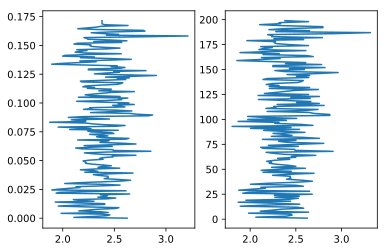

In [9]:
sample_number = 10
plt.subplot(1,2,1)
plt.plot(Vp_time[sample_number,:], time_upscaled)
plt.subplot(1,2,2)
plt.plot(Vp[sample_number,:], depth)


input1: Tensor("Const:0", shape=(2500, 246, 3), dtype=float32)


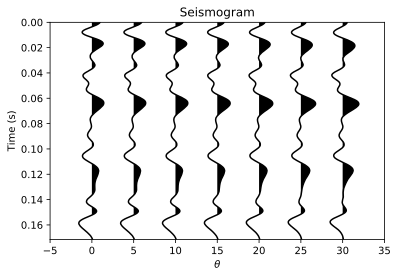

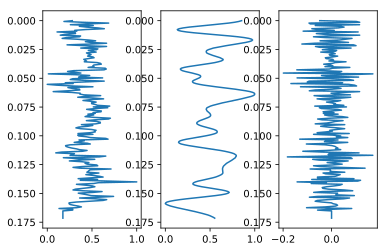

In [10]:
# Forward modeling results (Seismic gathers) (DONOT RUN IF NEW DATA IS NOT GENERATED)

# Test the forward modeling
bs=Vp_time.shape[0]
input11=np.zeros([bs,nt,3],dtype=np.float32)

input11[0:bs,:,0]=Vp_time[0:bs,:]
input11[0:bs,:,1]=Vs_time[0:bs,:]
input11[0:bs,:,2]=RHOB_time[0:bs,:]
# plt.plot(np.squeeze(input11))
# plt.show()

input111=tf.convert_to_tensor(input11,dtype=tf.float32)
# print("src:",src.shape)


tfsrc=tf.reshape(tf.constant(src,dtype=tf.float32),[src_len,1,1,1])


# print('tfsrc:',tfsrc)
# print('angle:',angle.shape)
tftheta=tf.convert_to_tensor(angle,dtype=tf.float32)
# print('tftheta:',tftheta)
seisgen=gather(input111,tftheta,tfsrc)


sess=tf.Session()
seis11,Rpp11=sess.run(seisgen)

sess.close()

seis=np.transpose(np.reshape(seis11,[-1,ntheta,nt]),[0,2,1])
Rpp=Rpp11#np.reshape(Rpp11,[bs,nt,ntheta])

sample_number = 20
wiggle(np.squeeze(seis[sample_number,:,:]),time_upscaled,theta)
plt.title("Seismogram")
plt.xlabel("$\\theta$")
plt.ylabel("Time (s)")
plt.show()

impedance_time = Vp_time * RHOB_time
impedance_time_sample = impedance_time[sample_number,:]
plt.subplot(1,3,1)
plt.plot((impedance_time_sample - np.min(impedance_time_sample))/(np.max(impedance_time_sample)-np.min(impedance_time_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,2)
seis_sample = np.squeeze(seis[sample_number,:,0])
plt.plot((seis_sample - np.min(seis_sample))/(np.max(seis_sample) - np.min(seis_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,3)
plt.plot(np.squeeze(Rpp[sample_number,:,0]), time_upscaled)
plt.gca().invert_yaxis()

In [16]:
# Exporting generated seismic data
np.save('../../../Data_generation_base_case/seismic_forward_modeled.npy', seis)
np.save('../../../Data_generation_base_case/Rpp_forward_modeled.npy', Rpp)


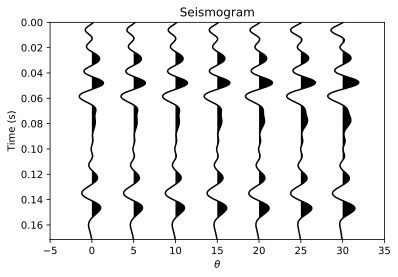

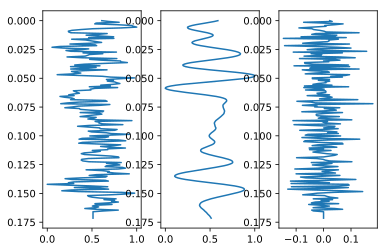

In [7]:
# Load forward modeled seismic data and Rpp
seis = np.load('../../../Data_generation_base_case/seismic_forward_modeled.npy')
Rpp = np.load('../../../Data_generation_base_case/Rpp_forward_modeled.npy')

sample_number = 12
wiggle(np.squeeze(seis[sample_number,:,:]),time_upscaled,theta)
plt.title("Seismogram")
plt.xlabel("$\\theta$")
plt.ylabel("Time (s)")
plt.show()

impedance_time = Vp_time * RHOB_time
impedance_time_sample = impedance_time[sample_number,:]
plt.subplot(1,3,1)
plt.plot((impedance_time_sample - np.min(impedance_time_sample))/(np.max(impedance_time_sample)-np.min(impedance_time_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,2)
seis_sample = np.squeeze(seis[sample_number,:,0])
plt.plot((seis_sample - np.min(seis_sample))/(np.max(seis_sample) - np.min(seis_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,3)
plt.plot(np.squeeze(Rpp[sample_number,:,0]), time_upscaled)
plt.gca().invert_yaxis()

In [8]:
# Import keras modules for CNN

from keras import layers, initializers, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling1D, MaxPooling2D, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import LeakyReLU, Reshape
from keras.models import Model, model_from_json, load_model
from keras.preprocessing import image
from keras.utils import layer_utils, normalize
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
# from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')

import sklearn.model_selection
import pydot

Using TensorFlow backend.


In [9]:
# Getting the input data (normalized) and output data 

# Reshape seismic gathers into (number of examples, angle, time) and normalize such that seismic traces have positive values
seis_reshaped = np.swapaxes(seis,1,2)
# seis_reshaped_normalized = (seis_reshaped - np.min(seis_reshaped))/(np.max(seis_reshaped)-np.min(seis_reshaped))
# Normalizing each trace individually
seis_test = np.reshape(seis_reshaped, (seis_reshaped.shape[0]*seis_reshaped.shape[1], seis_reshaped.shape[2]))
seis_reshaped_normalized = np.transpose(
    (seis_test.T - np.min(seis_test, axis=1))/(np.max(seis_test, axis=1) - np.min(seis_test, axis=1)))
seis_reshaped_normalized = np.reshape(seis_reshaped_normalized, (seis_reshaped.shape[0], seis_reshaped.shape[1], seis_reshaped.shape[2]))

# Selecting near(0 degree) and far (30 degree) angle traces from the full seismic gathers
row_idx = np.array([0, 6])
angle_seis_reshaped_normalized = seis_reshaped_normalized[:,row_idx,:]

# Output as Ip, Vp_Vs ratio
num_examples = Vp_time.shape[0]

# # Normalize Vp, Vs and Density
# Vp_time_norm = (Vp_time - np.min(Vp_time))/(np.max(Vp_time) - np.min(Vp_time))
# Vs_time_norm = (Vs_time - np.min(Vs_time))/(np.max(Vs_time) - np.min(Vs_time))
# RHOB_time_norm = (RHOB_time - np.min(RHOB_time))/(np.max(RHOB_time) - np.min(RHOB_time))

emodel = np.concatenate((Vp_time*RHOB_time,Vp_time/Vs_time), axis=1)
# emodel = np.concatenate((Vp_time_norm,Vs_time_norm,RHOB_time_norm), axis=1)
emodel = emodel.reshape((num_examples, 2, nt))


# Split data into train and test set - elastic model
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(angle_seis_reshaped_normalized, 
                                                                            emodel, test_size=0.2, random_state=1)
# X_train, X_test, Y_train_norm, Y_test_norm = sklearn.model_selection.train_test_split(angle_seis_reshaped_normalized, 
#                                                                             emodel, test_size=0.2, random_state=1)


# Add 4th dimension of number of channels=1 to the input data
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)


print ("number of training examples = " + str(X_train.shape[0]))
# print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
# print ("Y_train shape: " + str(Y_train_norm.shape))
# print ("X_val shape: " + str(X_val.shape))
# print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
# print ("Y_test shape: " + str(Y_test_norm.shape))

number of training examples = 2000
number of test examples = 500
X_train shape: (2000, 2, 246, 1)
Y_train shape: (2000, 2, 246)
X_test shape: (500, 2, 246, 1)
Y_test shape: (500, 2, 246)


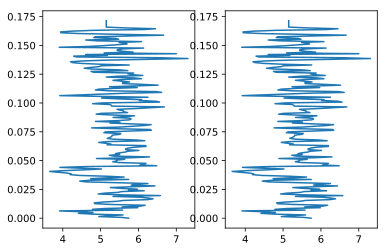

In [13]:
sample_number = 10

plt.subplot(1,2,1)
plt.plot(Y_train[sample_number, 0, :], time_upscaled)

plt.subplot(1,2,2)
plt.plot(Y_train[sample_number, 0, :], time_upscaled)

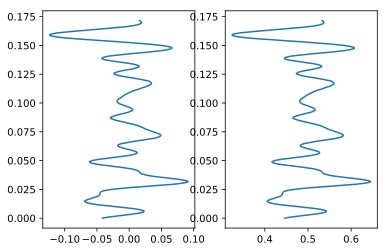

In [10]:
seis_reshaped_normalized = (seis_reshaped - np.min(seis_reshaped))/(np.max(seis_reshaped)-np.min(seis_reshaped))

plt.subplot(1,2,1)
plt.plot(np.squeeze(seis_reshaped[2,1,:]),time_upscaled)
plt.subplot(1,2,2)
plt.plot(np.squeeze(seis_reshaped_normalized[2,1,:]),time_upscaled)

In [11]:
# Building neural network for elastic properties prediction in Keras 
given_seed = 3 # For repeatibility

def elasticnet(input_shape):
    """
    Implementation of the AVONet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input_shape. Input = input angle gather 
    X_input = Input(input_shape)

    X = X_input

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(60, (1, 60), strides=(1, 1), name='conv0', padding='valid',
               kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn0')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv0')(X)
    # MAXPOOL
#     X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool0')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(1, (1, 60), strides=(1, 1), name='conv1', padding='valid',
               kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn1')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv1')(X)
    # MAXPOOL
#     X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool1')(X)
      

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
#     X = Dense(200, name='fc0',
#              kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
#     X = Activation('relu')(X)
    X = Dense(246*2, name='fc1',
             kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = Activation('relu')(X)
    X = Reshape((2, 246))(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='ElasticModel')

    return model
    ### END CODE HERE ###

In [12]:
# Create the model
ElasticModel = elasticnet(X_train.shape[1:])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
# Summary and plot of the model

ElasticModel.summary()


# plot_model(AVOModel)
# SVG(model_to_dot(ElasticModel).create(prog='dot', format='svg'))
# plot_model(ElasticModel, to_file='./Figures/model_plot.png', show_shapes=True, show_layer_names=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2, 246, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 2, 187, 60)        3660      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 2, 187, 60)        240       
_________________________________________________________________
activation_1 (Activation)    (None, 2, 187, 60)        0         
_________________________________________________________________
drop_conv0 (Dropout)         (None, 2, 187, 60)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 128, 1)         3601      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 2, 128, 1)         4         
__________

In [80]:
# Learning rate scheduler
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 500.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [14]:
# Compile the model with optimization algorithm, loss function
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

ElasticModel.compile(loss='mean_squared_error', optimizer = adam)

In [19]:
# Removing previous best_model.h5 file
import os
os.remove("best_model_elastic_near_far_comparable_network.h5")

In [20]:
# Using early stopping and Model Checkpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=250)
mc = ModelCheckpoint('best_model_elastic_near_far_comparable_network.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [21]:
# Start the training
# Using learning rate scheduler
# lrate = LearningRateScheduler(step_decay)
# callbacks_list = [es, mc, lrate]
# history = ElasticModel.fit(X_train, Y_train, validation_split=0.2, 
#                            epochs=1500, batch_size=32, callbacks=callbacks_list, verbose=0)

history = ElasticModel.fit(X_train, Y_train, validation_split=0.2, 
                           epochs=1500, batch_size=32, callbacks=[es, mc],
                          verbose = 0)

Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_loss improved from inf to 1.54897, saving model to best_model_elastic_near_far_comparable_network.h5

Epoch 00002: val_loss improved from 1.54897 to 0.33634, saving model to best_model_elastic_near_far_comparable_network.h5

Epoch 00003: val_loss did not improve from 0.33634

Epoch 00004: val_loss improved from 0.33634 to 0.32470, saving model to best_model_elastic_near_far_comparable_network.h5

Epoch 00005: val_loss did not improve from 0.32470

Epoch 00006: val_loss did not improve from 0.32470

Epoch 00007: val_loss did not improve from 0.32470

Epoch 00008: val_loss improved from 0.32470 to 0.27071, saving model to best_model_elastic_near_far_comparable_network.h5

Epoch 00009: val_loss did not improve from 0.27071

Epoch 00010: val_loss improved from 0.27071 to 0.25881, saving model to best_model_elastic_near_far_comparable_network.h5

Epoch 00011: val_loss improved from 0.25881 to 0.24686, saving model to best_mod


Epoch 00125: val_loss did not improve from 0.20153

Epoch 00126: val_loss did not improve from 0.20153

Epoch 00127: val_loss did not improve from 0.20153

Epoch 00128: val_loss did not improve from 0.20153

Epoch 00129: val_loss did not improve from 0.20153

Epoch 00130: val_loss did not improve from 0.20153

Epoch 00131: val_loss did not improve from 0.20153

Epoch 00132: val_loss did not improve from 0.20153

Epoch 00133: val_loss did not improve from 0.20153

Epoch 00134: val_loss did not improve from 0.20153

Epoch 00135: val_loss did not improve from 0.20153

Epoch 00136: val_loss did not improve from 0.20153

Epoch 00137: val_loss did not improve from 0.20153

Epoch 00138: val_loss did not improve from 0.20153

Epoch 00139: val_loss did not improve from 0.20153

Epoch 00140: val_loss did not improve from 0.20153

Epoch 00141: val_loss did not improve from 0.20153

Epoch 00142: val_loss did not improve from 0.20153

Epoch 00143: val_loss did not improve from 0.20153

Epoch 00144


Epoch 00272: val_loss did not improve from 0.19526

Epoch 00273: val_loss did not improve from 0.19526

Epoch 00274: val_loss did not improve from 0.19526

Epoch 00275: val_loss did not improve from 0.19526

Epoch 00276: val_loss did not improve from 0.19526

Epoch 00277: val_loss did not improve from 0.19526

Epoch 00278: val_loss did not improve from 0.19526

Epoch 00279: val_loss did not improve from 0.19526

Epoch 00280: val_loss did not improve from 0.19526

Epoch 00281: val_loss did not improve from 0.19526

Epoch 00282: val_loss did not improve from 0.19526

Epoch 00283: val_loss did not improve from 0.19526

Epoch 00284: val_loss did not improve from 0.19526

Epoch 00285: val_loss did not improve from 0.19526

Epoch 00286: val_loss did not improve from 0.19526

Epoch 00287: val_loss did not improve from 0.19526

Epoch 00288: val_loss did not improve from 0.19526

Epoch 00289: val_loss did not improve from 0.19526

Epoch 00290: val_loss did not improve from 0.19526

Epoch 00291


Epoch 00414: val_loss did not improve from 0.19102

Epoch 00415: val_loss did not improve from 0.19102

Epoch 00416: val_loss did not improve from 0.19102

Epoch 00417: val_loss did not improve from 0.19102

Epoch 00418: val_loss did not improve from 0.19102

Epoch 00419: val_loss improved from 0.19102 to 0.19062, saving model to best_model_elastic_near_far_comparable_network.h5

Epoch 00420: val_loss did not improve from 0.19062

Epoch 00421: val_loss did not improve from 0.19062

Epoch 00422: val_loss did not improve from 0.19062

Epoch 00423: val_loss did not improve from 0.19062

Epoch 00424: val_loss did not improve from 0.19062

Epoch 00425: val_loss did not improve from 0.19062

Epoch 00426: val_loss did not improve from 0.19062

Epoch 00427: val_loss did not improve from 0.19062

Epoch 00428: val_loss did not improve from 0.19062

Epoch 00429: val_loss did not improve from 0.19062

Epoch 00430: val_loss did not improve from 0.19062

Epoch 00431: val_loss did not improve from 0


Epoch 00557: val_loss did not improve from 0.18666

Epoch 00558: val_loss did not improve from 0.18666

Epoch 00559: val_loss did not improve from 0.18666

Epoch 00560: val_loss did not improve from 0.18666

Epoch 00561: val_loss did not improve from 0.18666

Epoch 00562: val_loss did not improve from 0.18666

Epoch 00563: val_loss did not improve from 0.18666

Epoch 00564: val_loss improved from 0.18666 to 0.18643, saving model to best_model_elastic_near_far_comparable_network.h5

Epoch 00565: val_loss did not improve from 0.18643

Epoch 00566: val_loss did not improve from 0.18643

Epoch 00567: val_loss did not improve from 0.18643

Epoch 00568: val_loss did not improve from 0.18643

Epoch 00569: val_loss did not improve from 0.18643

Epoch 00570: val_loss did not improve from 0.18643

Epoch 00571: val_loss did not improve from 0.18643

Epoch 00572: val_loss did not improve from 0.18643

Epoch 00573: val_loss did not improve from 0.18643

Epoch 00574: val_loss improved from 0.18643 


Epoch 00704: val_loss did not improve from 0.18239

Epoch 00705: val_loss did not improve from 0.18239

Epoch 00706: val_loss did not improve from 0.18239

Epoch 00707: val_loss did not improve from 0.18239

Epoch 00708: val_loss did not improve from 0.18239

Epoch 00709: val_loss did not improve from 0.18239

Epoch 00710: val_loss did not improve from 0.18239

Epoch 00711: val_loss did not improve from 0.18239

Epoch 00712: val_loss did not improve from 0.18239

Epoch 00713: val_loss did not improve from 0.18239

Epoch 00714: val_loss did not improve from 0.18239

Epoch 00715: val_loss did not improve from 0.18239

Epoch 00716: val_loss did not improve from 0.18239

Epoch 00717: val_loss did not improve from 0.18239

Epoch 00718: val_loss did not improve from 0.18239

Epoch 00719: val_loss improved from 0.18239 to 0.18226, saving model to best_model_elastic_near_far_comparable_network.h5

Epoch 00720: val_loss did not improve from 0.18226

Epoch 00721: val_loss did not improve from 0


Epoch 00850: val_loss improved from 0.18046 to 0.18030, saving model to best_model_elastic_near_far_comparable_network.h5

Epoch 00851: val_loss did not improve from 0.18030

Epoch 00852: val_loss did not improve from 0.18030

Epoch 00853: val_loss did not improve from 0.18030

Epoch 00854: val_loss did not improve from 0.18030

Epoch 00855: val_loss did not improve from 0.18030

Epoch 00856: val_loss did not improve from 0.18030

Epoch 00857: val_loss did not improve from 0.18030

Epoch 00858: val_loss did not improve from 0.18030

Epoch 00859: val_loss did not improve from 0.18030

Epoch 00860: val_loss did not improve from 0.18030

Epoch 00861: val_loss did not improve from 0.18030

Epoch 00862: val_loss did not improve from 0.18030

Epoch 00863: val_loss did not improve from 0.18030

Epoch 00864: val_loss did not improve from 0.18030

Epoch 00865: val_loss did not improve from 0.18030

Epoch 00866: val_loss did not improve from 0.18030

Epoch 00867: val_loss did not improve from 0


Epoch 00997: val_loss did not improve from 0.17877

Epoch 00998: val_loss did not improve from 0.17877

Epoch 00999: val_loss did not improve from 0.17877

Epoch 01000: val_loss did not improve from 0.17877

Epoch 01001: val_loss did not improve from 0.17877

Epoch 01002: val_loss did not improve from 0.17877

Epoch 01003: val_loss did not improve from 0.17877

Epoch 01004: val_loss did not improve from 0.17877

Epoch 01005: val_loss did not improve from 0.17877

Epoch 01006: val_loss did not improve from 0.17877

Epoch 01007: val_loss did not improve from 0.17877

Epoch 01008: val_loss did not improve from 0.17877

Epoch 01009: val_loss improved from 0.17877 to 0.17876, saving model to best_model_elastic_near_far_comparable_network.h5

Epoch 01010: val_loss did not improve from 0.17876

Epoch 01011: val_loss did not improve from 0.17876

Epoch 01012: val_loss did not improve from 0.17876

Epoch 01013: val_loss did not improve from 0.17876

Epoch 01014: val_loss did not improve from 0


Epoch 01137: val_loss did not improve from 0.17634

Epoch 01138: val_loss improved from 0.17634 to 0.17616, saving model to best_model_elastic_near_far_comparable_network.h5

Epoch 01139: val_loss did not improve from 0.17616

Epoch 01140: val_loss did not improve from 0.17616

Epoch 01141: val_loss did not improve from 0.17616

Epoch 01142: val_loss did not improve from 0.17616

Epoch 01143: val_loss did not improve from 0.17616

Epoch 01144: val_loss did not improve from 0.17616

Epoch 01145: val_loss did not improve from 0.17616

Epoch 01146: val_loss did not improve from 0.17616

Epoch 01147: val_loss improved from 0.17616 to 0.17561, saving model to best_model_elastic_near_far_comparable_network.h5

Epoch 01148: val_loss did not improve from 0.17561

Epoch 01149: val_loss did not improve from 0.17561

Epoch 01150: val_loss did not improve from 0.17561

Epoch 01151: val_loss did not improve from 0.17561

Epoch 01152: val_loss did not improve from 0.17561

Epoch 01153: val_loss did


Epoch 01279: val_loss did not improve from 0.17206

Epoch 01280: val_loss did not improve from 0.17206

Epoch 01281: val_loss did not improve from 0.17206

Epoch 01282: val_loss did not improve from 0.17206

Epoch 01283: val_loss did not improve from 0.17206

Epoch 01284: val_loss did not improve from 0.17206

Epoch 01285: val_loss did not improve from 0.17206

Epoch 01286: val_loss did not improve from 0.17206

Epoch 01287: val_loss did not improve from 0.17206

Epoch 01288: val_loss did not improve from 0.17206

Epoch 01289: val_loss did not improve from 0.17206

Epoch 01290: val_loss did not improve from 0.17206

Epoch 01291: val_loss improved from 0.17206 to 0.17122, saving model to best_model_elastic_near_far_comparable_network.h5

Epoch 01292: val_loss did not improve from 0.17122

Epoch 01293: val_loss did not improve from 0.17122

Epoch 01294: val_loss did not improve from 0.17122

Epoch 01295: val_loss did not improve from 0.17122

Epoch 01296: val_loss did not improve from 0


Epoch 01427: val_loss did not improve from 0.16871

Epoch 01428: val_loss did not improve from 0.16871

Epoch 01429: val_loss did not improve from 0.16871

Epoch 01430: val_loss improved from 0.16871 to 0.16831, saving model to best_model_elastic_near_far_comparable_network.h5

Epoch 01431: val_loss did not improve from 0.16831

Epoch 01432: val_loss did not improve from 0.16831

Epoch 01433: val_loss did not improve from 0.16831

Epoch 01434: val_loss did not improve from 0.16831

Epoch 01435: val_loss did not improve from 0.16831

Epoch 01436: val_loss did not improve from 0.16831

Epoch 01437: val_loss did not improve from 0.16831

Epoch 01438: val_loss did not improve from 0.16831

Epoch 01439: val_loss did not improve from 0.16831

Epoch 01440: val_loss did not improve from 0.16831

Epoch 01441: val_loss did not improve from 0.16831

Epoch 01442: val_loss did not improve from 0.16831

Epoch 01443: val_loss did not improve from 0.16831

Epoch 01444: val_loss did not improve from 0

In [15]:
# load the saved model
ElasticModel = load_model('best_model_elastic_near_far_comparable_network.h5')

Instructions for updating:
Use tf.cast instead.


In [16]:
# Testing and evaluating the model
preds = ElasticModel.evaluate(X_test, Y_test, batch_size=32, verbose=0, sample_weight=None)
print()
print ("Loss = " + str(preds))
# print ("Test Accuracy = " + str(preds[1]))


Loss = 0.16696243298053742


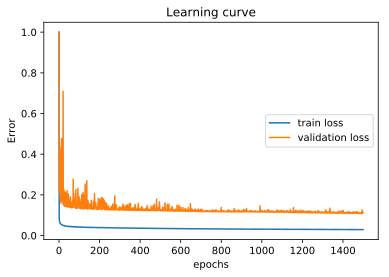

In [37]:
# Plotting the learning curve 
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.plot(history.history['loss']/np.max(history.history['loss']))
plt.plot(history.history['val_loss']/np.max(history.history['val_loss']))
# plt.yscale("log")
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])


plt.title('Learning curve')
# plt.ylabel('Error/Accuracy')
plt.ylabel('Error')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'], loc='center right')
# plt.savefig('/Figures/learning_curve_08Nov.png', bbox_inches='tight')

In [17]:
# Predict training and test data using the trained network
test_output = ElasticModel.predict(X_test)
train_output = ElasticModel.predict(X_train)

(1.4, 2.2)

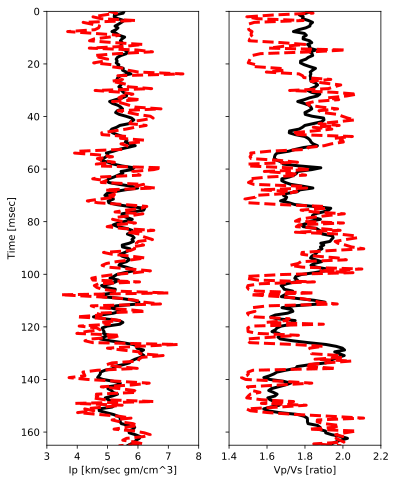

In [18]:
# Checking training data

sample_number = 25
f, axarr = plt.subplots(1, 2, sharey = True, figsize=(6,8))

axarr[0].plot(train_output[sample_number, 0, :], time_upscaled*1e3, '-k', label='predicted', linewidth=3)
axarr[0].plot(Y_train[sample_number, 0, :], time_upscaled*1e3, '--r', label='true', linewidth=3)
axarr[0].set_xlabel("Ip [km/sec gm/cm^3]")
axarr[0].set_ylabel("Time [msec]")
axarr[0].invert_yaxis()
axarr[0].set_xlim(3,8)
axarr[0].set_ylim(0,165)

axarr[1].plot(train_output[sample_number, 1, :], time_upscaled*1e3, '-k', linewidth=3)
axarr[1].plot(Y_train[sample_number, 1, :], time_upscaled*1e3, '--r', linewidth=3)
axarr[1].set_xlabel("Vp/Vs [ratio]")
# axarr[1].set_ylabel("Time [msec]")
axarr[1].invert_yaxis()
axarr[1].set_xlim(1.4,2.2)

# axarr[2].plot(train_output[sample_number, 2, :], time_upscaled, '-k')
# axarr[2].plot(Y_train[sample_number, 2, :], time_upscaled, '--r')
# axarr[2].set_xlabel("RHOB")
# axarr[2].set_ylabel("Time")
# axarr[2].invert_yaxis()
# axarr[2].set_xlim(1.5,3)

(1.4, 2.2)

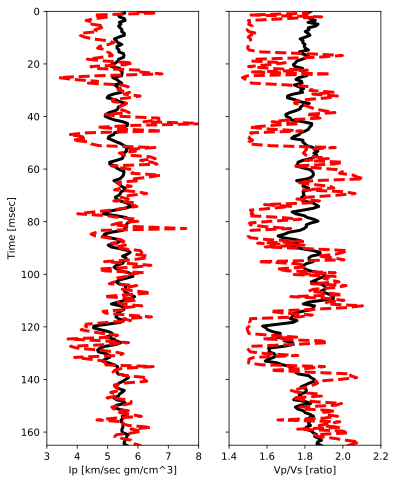

In [19]:
# Checking testing data

sample_number = 12
f, axarr = plt.subplots(1, 2, sharey = True, figsize=(6,8))

axarr[0].plot(test_output[sample_number, 0, :], time_upscaled*1e3, '-k', label='predicted', linewidth=3)
axarr[0].plot(Y_test[sample_number, 0, :], time_upscaled*1e3, '--r', label='true', linewidth=3)
axarr[0].set_xlabel("Ip [km/sec gm/cm^3]")
axarr[0].set_ylabel("Time [msec]")
axarr[0].invert_yaxis()
axarr[0].set_xlim(3,8)
axarr[0].set_ylim(0,165)

axarr[1].plot(test_output[sample_number, 1, :], time_upscaled*1e3, '-k', linewidth=3)
axarr[1].plot(Y_test[sample_number, 1, :], time_upscaled*1e3, '--r', linewidth=3)
axarr[1].set_xlabel("Vp/Vs [ratio]")
# axarr[1].set_ylabel("Time [msec]")
axarr[1].invert_yaxis()
axarr[1].set_xlim(1.4,2.2)

# axarr[2].plot(test_output[sample_number, 2, :], time_upscaled, '-k')
# axarr[2].plot(Y_test[sample_number, 2, :], time_upscaled, '--r')
# axarr[2].set_xlabel("RHOB")
# axarr[2].set_ylabel("Time")
# axarr[2].invert_yaxis()
# axarr[2].set_xlim(1.5,3)

In [39]:
# Correlation coefficient between true and predicted traces 

Ip_corr_train = np.zeros(train_output.shape[0])
Vp_Vs_corr_train = np.zeros(train_output.shape[0])
# RHOB_corr_train = np.zeros(train_output.shape[0])
for i in range(train_output.shape[0]):
    Ip_corr_train[i] = np.corrcoef(train_output[i,0,:], Y_train[i,0,:])[0,1]
    Vp_Vs_corr_train[i] = np.corrcoef(train_output[i,1,:], Y_train[i,1,:])[0,1]
#     RHOB_corr_train[i] = np.corrcoef(train_output[i,2,:], Y_train[i,2,:])[0,1]
    
Ip_corr_test = np.zeros(test_output.shape[0])
Vp_Vs_corr_test = np.zeros(test_output.shape[0])
# RHOB_corr_test = np.zeros(test_output.shape[0])
for i in range(test_output.shape[0]):
    Ip_corr_test[i] = np.corrcoef(test_output[i,0,:], Y_test[i,0,:])[0,1]
    Vp_Vs_corr_test[i] = np.corrcoef(test_output[i,1,:], Y_test[i,1,:])[0,1]
#     RHOB_corr_test[i] = np.corrcoef(test_output[i,2,:], Y_test[i,2,:])[0,1]

    
# Average correlation coefficient
print("Average correlation in Ip for training data = ", np.mean(Ip_corr_train))
print("Average correlation in Vp_Vs for training data = ", np.mean(Vp_Vs_corr_train))
# print("Average correlation in RHOB for training data = ", np.mean(RHOB_corr_train))

print("Average correlation in Ip for training data = ", np.mean(Ip_corr_test))
print("Average correlation in Vp_Vs for training data = ", np.mean(Vp_Vs_corr_test))
# print("Average correlation in RHOB for training data = ", np.mean(RHOB_corr_test))

Average correlation in Ip for training data =  0.565993739503398
Average correlation in Vp_Vs for training data =  0.5831731391877472
Average correlation in Ip for training data =  0.5361737984986417
Average correlation in Vp_Vs for training data =  0.553191925357288


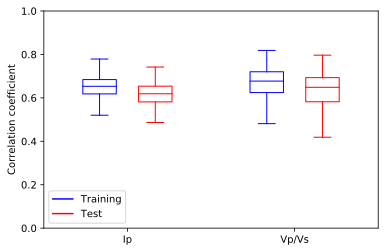

In [41]:
# Box plot of correlation coefficients 

from pylab import plot, show, savefig, xlim, figure, \
                hold, ylim, legend, boxplot, setp, axes

# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    setp(bp['boxes'][0], color='blue')
    setp(bp['caps'][0], color='blue')
    setp(bp['caps'][1], color='blue')
    setp(bp['whiskers'][0], color='blue')
    setp(bp['whiskers'][1], color='blue')
#     setp(bp['fliers'][0], color='blue')
#     setp(bp['fliers'][1], color='blue')
    setp(bp['medians'][0], color='blue')

    setp(bp['boxes'][1], color='red')
    setp(bp['caps'][2], color='red')
    setp(bp['caps'][3], color='red')
    setp(bp['whiskers'][2], color='red')
    setp(bp['whiskers'][3], color='red')
#     setp(bp['fliers'][2], color='red')
#     setp(bp['fliers'][3], color='red')
    setp(bp['medians'][1], color='red')

A= [Ip_corr_train, Ip_corr_test]
B = [Vp_Vs_corr_train, Vp_Vs_corr_test]
# C = [RHOB_corr_train, RHOB_corr_test]

fig = figure()
ax = axes()

# first boxplot pair
bp = boxplot(A, positions = [1, 2], widths = 0.6, showfliers=False)
setBoxColors(bp)

# second boxplot pair
bp = boxplot(B, positions = [4, 5], widths = 0.6, showfliers=False)
setBoxColors(bp)

# # thrid boxplot pair
# bp = boxplot(C, positions = [7, 8], widths = 0.6, showfliers=False)
# setBoxColors(bp)

# set axes limits and labels
# xlim(0,9)
xlim(0,6)
ylim(0,1)
# ax.set_xticklabels(['Vp', 'Vs', 'RHOB'])
ax.set_xticklabels(['Ip', 'Vp/Vs'])
# ax.set_xticks([1.5, 4.5, 7.5])
ax.set_xticks([1.5, 4.5])
plt.ylabel('Correlation coefficient')

# draw temporary red and blue lines and use them to create a legend
hB, = plot([1,1],'b-')
hR, = plot([1,1],'r-')
legend((hB, hR),('Training', 'Test'), loc='lower left')
hB.set_visible(False)
hR.set_visible(False)

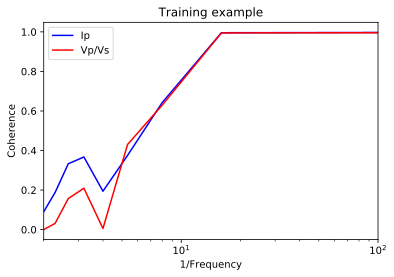

In [42]:
# Spectral coherence between true and predicted (training data)

sample_number = 25
Cxy_ip, wavenumber_ip = plt.cohere(Y_train[sample_number,0,:], train_output[sample_number,0,:], NFFT=16, Fs=1, color="blue")
Cxy_vp_vs, wavenumber_vp_vs = plt.cohere(Y_train[sample_number,1,:], train_output[sample_number,1,:], NFFT=16, Fs=1, color="red") 
# Cxy_rhob, wavenumber_rhob = plt.cohere(Y_train[sample_number,2,:], train_output[sample_number,2,:], NFFT=16, Fs=1, color="black")

# Adding epsilon to the first wavenumber value
wavenumber_ip[0] = wavenumber_ip[0] + 0.001
wavenumber_vp_vs[0] = wavenumber_vp_vs[0] + 0.001
# wavenumber_rhob[0] = wavenumber_rhob[0] + 0.001

plt.plot(1/wavenumber_ip, Cxy_ip, color="blue")
plt.plot(1/wavenumber_vp_vs, Cxy_vp_vs, color="red")
# plt.plot(1/wavenumber_rhob, Cxy_rhob, color="black")

plt.xlim(100,2)
plt.gca().invert_xaxis()
plt.xscale("log")

# plt.gca().legend(('Vp','Vs', 'RHOB'))
plt.gca().legend(('Ip','Vp/Vs'))
plt.xlabel('1/Frequency')
plt.ylabel('Coherence')
plt.title('Training example')
plt.grid(b=False)

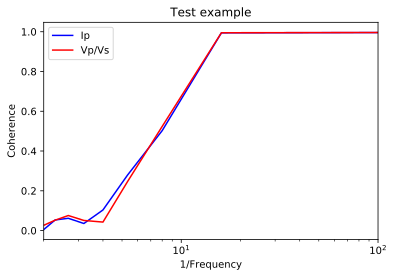

In [43]:
# Spectral coherence between true and predicted (training data)

sample_number = 12
Cxy_ip, wavenumber_ip = plt.cohere(Y_test[sample_number,0,:], test_output[sample_number,0,:], NFFT=16, Fs=1, color="blue")
Cxy_vp_vs, wavenumber_vp_vs = plt.cohere(Y_test[sample_number,1,:], test_output[sample_number,1,:], NFFT=16, Fs=1, color="red") 
# Cxy_rhob, wavenumber_rhob = plt.cohere(Y_test[sample_number,2,:], test_output[sample_number,2,:], NFFT=16, Fs=1, color="black")

# Adding epsilon to the first wavenumber value
wavenumber_ip[0] = wavenumber_ip[0] + 0.001
wavenumber_vp_vs[0] = wavenumber_vp_vs[0] + 0.001
# wavenumber_rhob[0] = wavenumber_rhob[0] + 0.001

plt.plot(1/wavenumber_ip, Cxy_ip, color="blue")
plt.plot(1/wavenumber_vp_vs, Cxy_vp_vs, color="red")
# plt.plot(1/wavenumber_rhob, Cxy_rhob, color="black")

plt.xlim(100,2)
plt.gca().invert_xaxis()
plt.xscale("log")

# plt.gca().legend(('Vp','Vs', 'RHOB'))
plt.gca().legend(('Ip','Vp/Vs'))
plt.xlabel('1/Frequency')
plt.ylabel('Coherence')
plt.title('Test example')
plt.grid(b=False)

## Predicting petrophysical properties from elastic properties of previous network

In [20]:
# Use predicted Ip, Vp/Vs from network
# Concatenate Ip, Vp/Vs

num_examples = Vp_time.shape[0]
emodel_true = np.concatenate((Vp_time*RHOB_time,Vp_time/Vs_time,), axis=1)
emodel_true = emodel.reshape((num_examples, 2, nt))

# emodel_norm = ElasticModel.predict(np.expand_dims(seis_reshaped_normalized, axis=3))
emodel = ElasticModel.predict(np.expand_dims(angle_seis_reshaped_normalized, axis=3))


# Concatenate Porosity, Vclay
num_examples = porosity.shape[0]
ndepth = porosity.shape[1]

# Normalize porosity
porosity_norm = (porosity - np.min(porosity))/(np.max(porosity) - np.min(porosity))

# petromodel = np.concatenate((porosity,vclay,Sw), axis=1)
# petromodel = petromodel.reshape((num_examples, 3, ndepth))
petromodel = np.concatenate((porosity_norm,vclay), axis=1)
petromodel = petromodel.reshape((num_examples, 2, ndepth))

# Split data into train and test set - elastic model predicted
X_train, X_test, Y_train_norm, Y_test_norm = sklearn.model_selection.train_test_split(emodel, 
                                                                            petromodel, test_size=0.2, random_state=1)

# Split data into train and test set - elastic model true
X_train_true, X_test_true, Y_train_true_norm, Y_test_true_norm = sklearn.model_selection.train_test_split(emodel_true, 
                                                                            petromodel, test_size=0.2, random_state=1)


# Add 4th dimension of number of channels=1 to the input data
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)


print ("number of training examples = " + str(X_train.shape[0]))
# print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train_norm.shape))
# print ("X_val shape: " + str(X_val.shape))
# print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test_norm.shape))

number of training examples = 2000
number of test examples = 500
X_train shape: (2000, 2, 246, 1)
Y_train shape: (2000, 2, 199)
X_test shape: (500, 2, 246, 1)
Y_test shape: (500, 2, 199)


In [21]:
# Building neural network for petrophysical properties prediction in Keras 
given_seed = 3 # For repeatibility

def elastic_petronet(input_shape):
    """
    Implementation of the AVONet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input_shape. Input = input angle gather 
    X_input = Input(input_shape)

    X = X_input

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(8, (1, 30), strides=(1, 2), name='conv0', padding='valid',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn0')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv0')(X)
    # MAXPOOL
#     X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool0')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(4, (1, 60), strides=(1, 2), name='conv1', padding='valid',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn1')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv1')(X)
    # MAXPOOL
#     X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool1')(X)

#     # CONV -> BN -> RELU Block applied to X
#     X = Conv2D(16, (1, 30), strides=(1, 2), name='conv2', padding='same',
#                kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
#     X = BatchNormalization(axis=-1, name='bn2')(X)
#     X = Activation('relu')(X)
#     X = Dropout(rate=0.3, name='drop_conv2')(X)
#     # MAXPOOL
# #     X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool1')(X)

#     # CONV -> BN -> RELU Block applied to X
#     X = Conv2D(8, (1, 60), strides=(1, 2), name='conv3', padding='same',
#                kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
#     X = BatchNormalization(axis=-1, name='bn3')(X)
#     X = Activation('relu')(X)
#     X = Dropout(rate=0.3, name='drop_conv3')(X)
#     # MAXPOOL
# #     X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool1')(X)



    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
#     X = Dense(1200, name='fc1')(X)
#     X = Activation('relu')(X)
    X = Dense(199*2, name='fc1')(X)
    X = Activation('relu')(X)
    
    X = Reshape((2, 199))(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='ElasticPetroModel')

    return model
    ### END CODE HERE ###

In [22]:
# Create the model
ElasticPetroModel = elastic_petronet(X_train.shape[1:])

In [23]:
# Summary and plot of the model

ElasticPetroModel.summary()


# plot_model(AVOModel)
# SVG(model_to_dot(ElasticModel).create(prog='dot', format='svg'))
# plot_model(ElasticModel, to_file='./Figures/model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2, 246, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 2, 109, 8)         248       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 2, 109, 8)         32        
_________________________________________________________________
activation_4 (Activation)    (None, 2, 109, 8)         0         
_________________________________________________________________
drop_conv0 (Dropout)         (None, 2, 109, 8)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 25, 4)          1924      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 2, 25, 4)          16        
__________

In [27]:
# Learning rate scheduler
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 50.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [24]:
# Compile the model with optimization algorithm, loss function
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

ElasticPetroModel.compile(loss='mean_squared_error', optimizer = adam)

In [45]:
# Removing previous best_model.h5 file
import os
os.remove("best_model_elastic_petro_near_far_comparable_network.h5")

In [46]:
# Using early stopping and Model Checkpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('best_model_elastic_petro_near_far_comparable_network.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [47]:
# Start the training
# Using learning rate scheduler
# lrate = LearningRateScheduler(step_decay)
# callbacks_list = [es, mc, lrate]
# history = ElasticModel.fit(X_train, Y_train, validation_split=0.2, 
#                            epochs=1500, batch_size=32, callbacks=callbacks_list, verbose=0)

history = ElasticPetroModel.fit(X_train, Y_train_norm, validation_split=0.2, 
                           epochs=1500, batch_size=32, callbacks=[es, mc],
                          verbose = 0)


Epoch 00001: val_loss improved from inf to 0.08598, saving model to best_model_elastic_petro_near_far_comparable_network.h5

Epoch 00002: val_loss improved from 0.08598 to 0.06925, saving model to best_model_elastic_petro_near_far_comparable_network.h5

Epoch 00003: val_loss improved from 0.06925 to 0.06480, saving model to best_model_elastic_petro_near_far_comparable_network.h5

Epoch 00004: val_loss improved from 0.06480 to 0.06383, saving model to best_model_elastic_petro_near_far_comparable_network.h5

Epoch 00005: val_loss improved from 0.06383 to 0.06335, saving model to best_model_elastic_petro_near_far_comparable_network.h5

Epoch 00006: val_loss improved from 0.06335 to 0.06313, saving model to best_model_elastic_petro_near_far_comparable_network.h5

Epoch 00007: val_loss improved from 0.06313 to 0.06290, saving model to best_model_elastic_petro_near_far_comparable_network.h5

Epoch 00008: val_loss improved from 0.06290 to 0.06266, saving model to best_model_elastic_petro_nea


Epoch 00115: val_loss did not improve from 0.04844

Epoch 00116: val_loss did not improve from 0.04844

Epoch 00117: val_loss did not improve from 0.04844

Epoch 00118: val_loss did not improve from 0.04844

Epoch 00119: val_loss did not improve from 0.04844

Epoch 00120: val_loss did not improve from 0.04844

Epoch 00121: val_loss did not improve from 0.04844

Epoch 00122: val_loss did not improve from 0.04844

Epoch 00123: val_loss did not improve from 0.04844

Epoch 00124: val_loss did not improve from 0.04844

Epoch 00125: val_loss did not improve from 0.04844

Epoch 00126: val_loss did not improve from 0.04844

Epoch 00127: val_loss did not improve from 0.04844

Epoch 00128: val_loss did not improve from 0.04844

Epoch 00129: val_loss did not improve from 0.04844

Epoch 00130: val_loss did not improve from 0.04844

Epoch 00131: val_loss did not improve from 0.04844

Epoch 00132: val_loss did not improve from 0.04844

Epoch 00133: val_loss did not improve from 0.04844

Epoch 00134


Epoch 00263: val_loss did not improve from 0.04806

Epoch 00264: val_loss did not improve from 0.04806

Epoch 00265: val_loss did not improve from 0.04806

Epoch 00266: val_loss did not improve from 0.04806

Epoch 00267: val_loss did not improve from 0.04806

Epoch 00268: val_loss did not improve from 0.04806

Epoch 00269: val_loss did not improve from 0.04806

Epoch 00270: val_loss did not improve from 0.04806

Epoch 00271: val_loss did not improve from 0.04806

Epoch 00272: val_loss did not improve from 0.04806

Epoch 00273: val_loss did not improve from 0.04806

Epoch 00274: val_loss did not improve from 0.04806

Epoch 00275: val_loss did not improve from 0.04806

Epoch 00276: val_loss did not improve from 0.04806

Epoch 00277: val_loss did not improve from 0.04806

Epoch 00278: val_loss did not improve from 0.04806

Epoch 00279: val_loss did not improve from 0.04806

Epoch 00280: val_loss did not improve from 0.04806

Epoch 00281: val_loss did not improve from 0.04806

Epoch 00282

In [25]:
# load the saved model
ElasticPetroModel = load_model('best_model_elastic_petro_near_far_comparable_network.h5')

In [26]:
# Testing and evaluating the model
preds = ElasticPetroModel.evaluate(X_test, Y_test_norm, batch_size=32, verbose=0, sample_weight=None)
print()
print ("Loss = " + str(preds))
# print ("Test Accuracy = " + str(preds[1]))


Loss = 0.04787577444314957


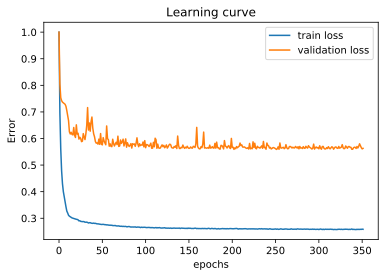

In [53]:
# Plotting the learning curve 
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.plot(history.history['loss']/np.max(history.history['loss']))
plt.plot(history.history['val_loss']/np.max(history.history['val_loss']))
# plt.yscale("log")
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])


plt.title('Learning curve')
# plt.ylabel('Error/Accuracy')
plt.ylabel('Error')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'], loc='upper right')
# plt.savefig('/Figures/learning_curve_08Nov.png', bbox_inches='tight')

In [27]:
# Predict training and test data using the trained network
test_output_norm = ElasticPetroModel.predict(X_test)
train_output_norm = ElasticPetroModel.predict(X_train)

# Initialization
train_output = np.zeros(train_output_norm.shape)
test_output = np.zeros(test_output_norm.shape)
Y_train = np.zeros(Y_train_norm.shape)
Y_test = np.zeros(Y_test_norm.shape)

# Back transforming porosity to unnormalized values 
train_output[:,0,:] = train_output_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)
test_output[:,0,:] = test_output_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)

train_output[:,1,:] = train_output_norm[:,1,:]
test_output[:,1,:] = test_output_norm[:,1,:]

Y_train[:,0,:] = Y_train_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)
Y_test[:,0,:] = Y_test_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)

Y_train[:,1,:] = Y_train_norm[:,1,:]
Y_test[:,1,:] = Y_test_norm[:,1,:]

In [70]:
# RMSE with respect to mean 
rmse_train = np.sqrt(np.mean(((train_output - Y_train)**2).mean(axis=2), axis = 0))/np.mean(np.mean(Y_train, axis = 0), axis=1)
rmse_test = np.sqrt(np.mean(((test_output - Y_test)**2).mean(axis=2), axis = 0))/np.mean(np.mean(Y_test, axis = 0), axis=1)

print("Training error = ", rmse_train)
print("Test error = ", rmse_test)

Training error =  [0.17795548 0.34605713]
Test error =  [0.18924002 0.37196291]


(0, 1)

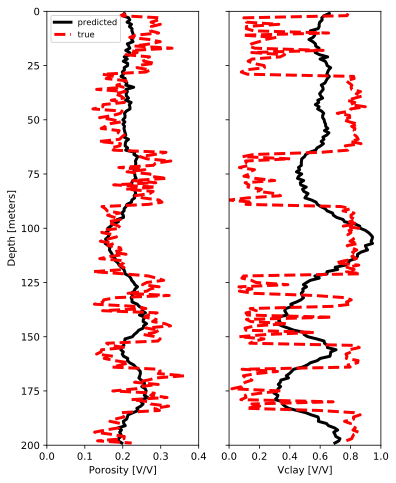

In [29]:
# Checking training data

sample_number = 25
f, axarr = plt.subplots(1, 2, sharey = True, figsize=(6,8))

axarr[0].plot(train_output[sample_number, 0, :], depth, '-k', label='predicted', linewidth=3)
axarr[0].plot(Y_train[sample_number, 0, :], depth, '--r', label='true', linewidth=3)
axarr[0].set_xlabel("Porosity [V/V]")
axarr[0].set_ylabel("Depth [meters]")
axarr[0].invert_yaxis()
axarr[0].set_xlim(0,0.4)
axarr[0].set_ylim(0,200)
axarr[0].legend(fontsize = 'small')

axarr[1].plot(train_output[sample_number, 1, :], depth, '-k', linewidth=3)
axarr[1].plot(Y_train[sample_number, 1, :], depth, '--r', linewidth=3)
axarr[1].set_xlabel("Vclay [V/V]")
# axarr[1].set_ylabel("Depth [meters]")
axarr[1].invert_yaxis()
axarr[1].set_xlim(0,1)

# axarr[2].plot(train_output[sample_number, 2, :], depth, '-k')
# axarr[2].plot(Y_train[sample_number, 2, :], depth, '--r')
# axarr[2].set_xlabel("Sw")
# axarr[2].set_ylabel("Depth")
# axarr[2].invert_yaxis()
# axarr[2].set_xlim(1.5,3)

(0, 1)

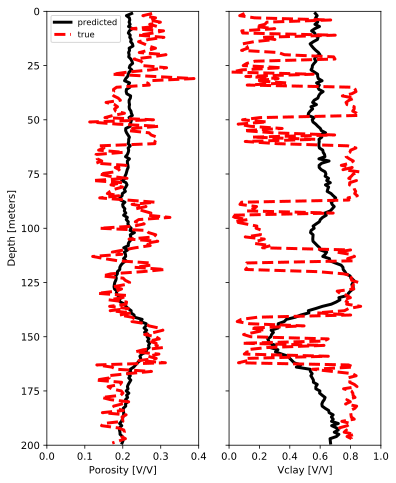

In [30]:
# Checking testing data

sample_number = 12
f, axarr = plt.subplots(1, 2, sharey = True, figsize=(6,8))

axarr[0].plot(test_output[sample_number, 0, :], depth, '-k', label='predicted', linewidth=3)
axarr[0].plot(Y_test[sample_number, 0, :], depth, '--r', label='true', linewidth=3)
axarr[0].set_xlabel("Porosity [V/V]")
axarr[0].set_ylabel("Depth [meters]")
axarr[0].invert_yaxis()
axarr[0].set_xlim(0,0.4)
axarr[0].set_ylim(0,200)
axarr[0].legend(fontsize = 'small')

axarr[1].plot(test_output[sample_number, 1, :], depth, '-k', linewidth=3)
axarr[1].plot(Y_test[sample_number, 1, :], depth, '--r', linewidth=3)
axarr[1].set_xlabel("Vclay [V/V]")
# axarr[1].set_ylabel("Depth")
axarr[1].invert_yaxis()
axarr[1].set_xlim(0,1)

# axarr[2].plot(test_output[sample_number, 2, :], depth, '-k')
# axarr[2].plot(Y_test[sample_number, 2, :], depth, '--r')
# axarr[2].set_xlabel("Sw")
# axarr[2].set_ylabel("Depth")
# axarr[2].invert_yaxis()
# axarr[2].set_xlim(1.5,3)

In [57]:
# Correlation coefficient between true and predicted traces 

Porosity_corr_train = np.zeros(train_output.shape[0])
Vclay_corr_train = np.zeros(train_output.shape[0])
# Sw_corr_train = np.zeros(train_output.shape[0])
for i in range(train_output.shape[0]):
    Porosity_corr_train[i] = np.corrcoef(train_output[i,0,:], Y_train[i,0,:])[0,1]
    Vclay_corr_train[i] = np.corrcoef(train_output[i,1,:], Y_train[i,1,:])[0,1]
#     Sw_corr_train[i] = np.corrcoef(train_output[i,2,:], Y_train[i,2,:])[0,1]
    
Porosity_corr_test = np.zeros(test_output.shape[0])
Vclay_corr_test = np.zeros(test_output.shape[0])
# Sw_corr_test = np.zeros(test_output.shape[0])
for i in range(test_output.shape[0]):
    Porosity_corr_test[i] = np.corrcoef(test_output[i,0,:], Y_test[i,0,:])[0,1]
    Vclay_corr_test[i] = np.corrcoef(test_output[i,1,:], Y_test[i,1,:])[0,1]
#     Sw_corr_test[i] = np.corrcoef(test_output[i,2,:], Y_test[i,2,:])[0,1]

    
# Average correlation coefficient
print("Average correlation in porosity for training data = ", np.mean(Porosity_corr_train))
print("Average correlation in Vclay for training data = ", np.mean(Vclay_corr_train))
# print("Average correlation in Sw for training data = ", np.mean(Sw_corr_train))

print("Average correlation in porosity for test data = ", np.mean(Porosity_corr_test))
print("Average correlation in Vclay for test data = ", np.mean(Vclay_corr_test))
# print("Average correlation in Sw for test data = ", np.mean(Sw_corr_test))

Average correlation in porosity for training data =  0.4939556799691097
Average correlation in Vclay for training data =  0.5227303896337547
Average correlation in porosity for test data =  0.45532540843210834
Average correlation in Vclay for test data =  0.48469901775234214


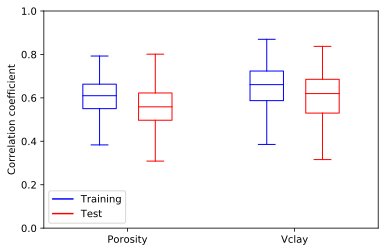

In [84]:
# Box plot of correlation coefficients 

from pylab import plot, show, savefig, xlim, figure, \
                hold, ylim, legend, boxplot, setp, axes

# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    setp(bp['boxes'][0], color='blue')
    setp(bp['caps'][0], color='blue')
    setp(bp['caps'][1], color='blue')
    setp(bp['whiskers'][0], color='blue')
    setp(bp['whiskers'][1], color='blue')
#     setp(bp['fliers'][0], color='blue')
#     setp(bp['fliers'][1], color='blue')
    setp(bp['medians'][0], color='blue')

    setp(bp['boxes'][1], color='red')
    setp(bp['caps'][2], color='red')
    setp(bp['caps'][3], color='red')
    setp(bp['whiskers'][2], color='red')
    setp(bp['whiskers'][3], color='red')
#     setp(bp['fliers'][2], color='red')
#     setp(bp['fliers'][3], color='red')
    setp(bp['medians'][1], color='red')

# Some fake data to plot
A= [Porosity_corr_train, Porosity_corr_test]
B = [Vclay_corr_train, Vclay_corr_test]
# C = [Sw_corr_train, Sw_corr_test]

fig = figure()
ax = axes()

# first boxplot pair
bp = boxplot(A, positions = [1, 2], widths = 0.6, showfliers=False)
setBoxColors(bp)

# second boxplot pair
bp = boxplot(B, positions = [4, 5], widths = 0.6, showfliers=False)
setBoxColors(bp)

# thrid boxplot pair
# bp = boxplot(C, positions = [7, 8], widths = 0.6, showfliers=False)
# setBoxColors(bp)

# set axes limits and labels
# xlim(0,9)
xlim(0,6)
ylim(0,1)
# ax.set_xticklabels(['Porosity', 'Vclay', 'Sw'])
ax.set_xticklabels(['Porosity', 'Vclay'])
# ax.set_xticks([1.5, 4.5, 7.5])
ax.set_xticks([1.5, 4.5])
plt.ylabel('Correlation coefficient')

# draw temporary red and blue lines and use them to create a legend
hB, = plot([1,1],'b-')
hR, = plot([1,1],'r-')
legend((hB, hR),('Training', 'Test'), loc='lower left')
hB.set_visible(False)
hR.set_visible(False)

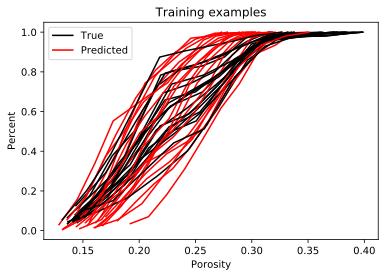

In [84]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output.shape[0],100):
    hist, bin_edges = np.histogram(Y_train[i,0,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(train_output[i,0,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
#     plt.hist(train_output[i,0,:], histtype='step', color='red')
    plt.xlabel('Porosity')
    plt.ylabel('Probability')
    plt.title('Training examples')

plt.legend(['True', 'Predicted'])




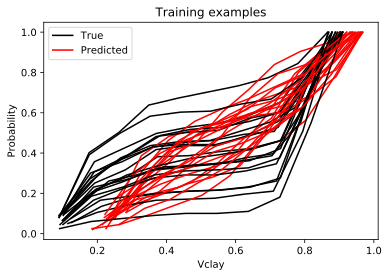

In [86]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output.shape[0],100):
    hist, bin_edges = np.histogram(Y_train[i,1,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(train_output[i,1,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
    plt.xlabel('Vclay')
    plt.ylabel('Probability')
    plt.title('Training examples')
    
plt.legend(['True', 'Predicted'])

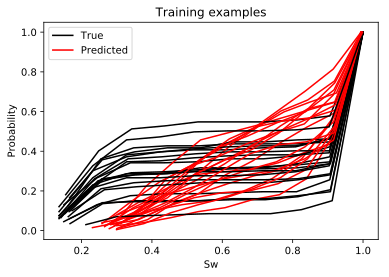

In [88]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output.shape[0],100):
    hist, bin_edges = np.histogram(Y_train[i,2,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(train_output[i,2,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
    plt.xlabel('Sw')
    plt.ylabel('Probability')
    plt.title('Training examples')
plt.legend(['True', 'Predicted'])

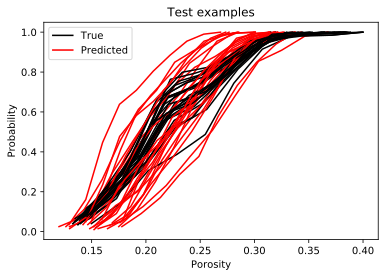

In [94]:
for i in np.arange(0,test_output.shape[0],20):
    hist, bin_edges = np.histogram(Y_test[i,0,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(test_output[i,0,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
    plt.xlabel('Porosity')
    plt.ylabel('Probability')
    plt.title('Test examples')
plt.legend(['True', 'Predicted'])    

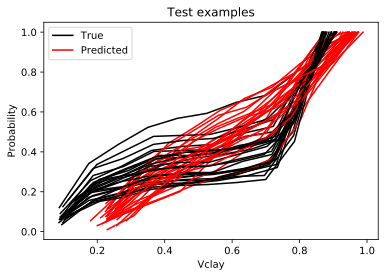

In [95]:
for i in np.arange(0,test_output.shape[0],20):
    hist, bin_edges = np.histogram(Y_test[i,1,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(test_output[i,1,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
    plt.xlabel('Vclay')
    plt.ylabel('Probability')
    plt.title('Test examples')
    
plt.legend(['True', 'Predicted'])

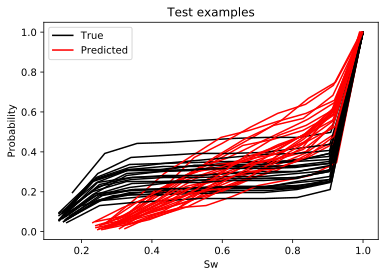

In [96]:
for i in np.arange(0,test_output.shape[0],20):
    hist, bin_edges = np.histogram(Y_test[i,2,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(test_output[i,2,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
    plt.xlabel('Sw')
    plt.ylabel('Probability')
    plt.title('Test examples')
    
plt.legend(['True', 'Predicted'])

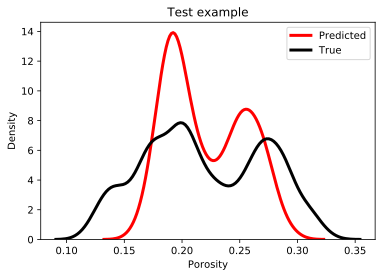

In [46]:
# Density estimate for true vs predicted (test example) Porosity

import seaborn as sns

sample_number = 12
sns.kdeplot(test_output[sample_number,0,:],  
             color='red', label='Predicted', linewidth=3,
            bw=0.01,
             clip=(np.min(test_output[sample_number,0,:]), np.max(test_output[sample_number,0,:])))
sns.kdeplot(Y_test[sample_number,0,:],  
             color='black', label='True', linewidth=3,
            bw=0.01,
             clip=(np.min(Y_test[sample_number,0,:]), np.max(Y_test[sample_number,0,:])))
plt.xlabel('Porosity')
plt.ylabel('Density')
plt.title('Test example')
plt.legend()

(-0.1, 1.1)

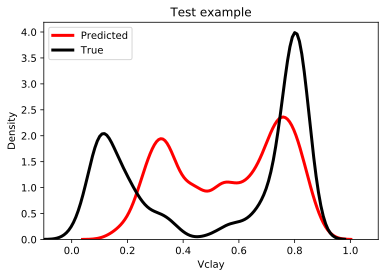

In [47]:
# Density estimate for true vs predicted (test example) Vclay

sample_number = 12

sns.kdeplot(test_output[sample_number,1,:],  
             color='red', label='Predicted', linewidth=3,
             bw=0.04,
           clip=(np.min(test_output[sample_number,1,:]), np.max(test_output[sample_number,1,:])))
sns.kdeplot(Y_test[sample_number,1,:],  
             color='black', label='True', linewidth=3,
            bw=0.04,
             clip=(np.min(Y_test[sample_number,1,:]), np.max(Y_test[sample_number,1,:])))
plt.xlabel('Vclay')
plt.ylabel('Density')
plt.title('Test example')
plt.legend()
plt.xlim(-0.1,1.1)

(-0.1, 1.1)

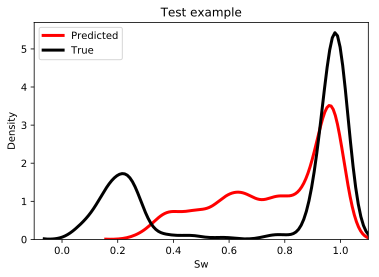

In [39]:
# Density estimate for true vs predicted (test example) Water saturation 

sample_number = 12

sns.kdeplot(test_output[sample_number,2,:],  
             color='red', label='Predicted', linewidth=3,
             bw=0.04,
           clip=(np.min(test_output[sample_number,2,:]), np.max(test_output[sample_number,2,:])))
sns.kdeplot(Y_test[sample_number,2,:],  
             color='black', label='True', linewidth=3,
            bw=0.04,
             clip=(np.min(Y_test[sample_number,2,:]), np.max(Y_test[sample_number,2,:])))
plt.xlabel('Sw')
plt.ylabel('Density')
plt.title('Test example')
plt.legend()
plt.xlim(-0.1,1.1)

({'var': 0.0013368790391030058,
  'len_scale': 20.873965391900793,
  'nugget': 3.817749230815582e-23},
 array([[ 2.88425738e-09, -2.34717955e-05, -2.66406498e-09],
        [-2.34717955e-05,  1.10828283e+00,  3.10742210e-05],
        [-2.66406498e-09,  3.10742210e-05,  2.73543525e-09]]))

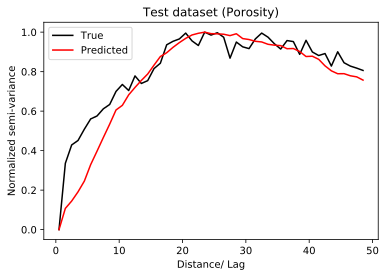

In [48]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 12
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_test[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Test dataset (Porosity)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, test_output[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

({'var': 0.048650084518368726,
  'len_scale': 24.330325377655797,
  'nugget': 5.3481394465696345e-30},
 array([[ 1.09512271e-05, -2.59557189e-03, -9.87913801e-06],
        [-2.59557189e-03,  4.46751612e+00,  3.77591871e-03],
        [-9.87913801e-06,  3.77591871e-03,  1.02231586e-05]]))

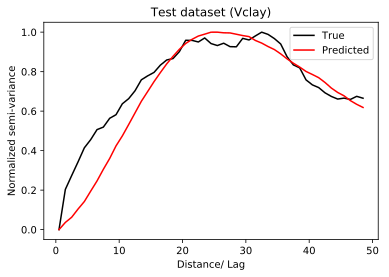

In [49]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 12
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_test[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Test dataset (Vclay)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, test_output[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

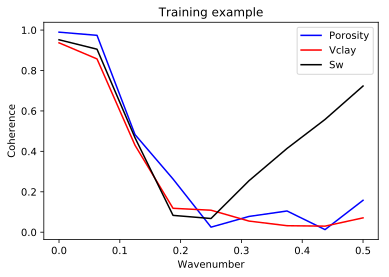

In [36]:
# Spectral coherence between true and predicted 

sample_number = 25
plt.cohere(Y_train[sample_number,0,:], train_output[sample_number,0,:], NFFT=16, Fs=1, color="blue")
plt.cohere(Y_train[sample_number,1,:], train_output[sample_number,1,:], NFFT=16, Fs=1, color="red") 
plt.cohere(Y_train[sample_number,2,:], train_output[sample_number,2,:], NFFT=16, Fs=1, color="black")


plt.gca().legend(('Porosity','Vclay', 'Sw'))
plt.xlabel('Wavenumber')
plt.ylabel('Coherence')
plt.title('Training example')
plt.grid(b=False)

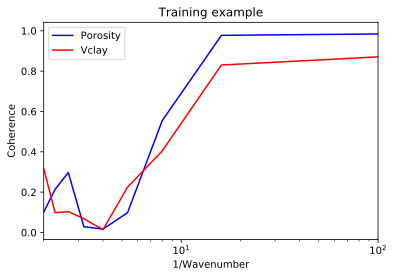

In [50]:
# Spectral coherence between true and predicted (training data)

sample_number = 25
Cxy_poro, wavenumber_poro = plt.cohere(Y_train[sample_number,0,:], train_output[sample_number,0,:], NFFT=16, Fs=1, color="blue")
Cxy_vclay, wavenumber_vclay = plt.cohere(Y_train[sample_number,1,:], train_output[sample_number,1,:], NFFT=16, Fs=1, color="red") 
# Cxy_sw, wavenumber_sw = plt.cohere(Y_test_petro[sample_number,2,:], test_output_petro[sample_number,2,:], NFFT=16, Fs=1, color="black")

# Adding epsilon to the first wavenumber value
wavenumber_poro[0] = wavenumber_poro[0] + 0.001
wavenumber_vclay[0] = wavenumber_vclay[0] + 0.001
# wavenumber_sw[0] = wavenumber_sw[0] + 0.001

plt.plot(1/wavenumber_poro, Cxy_poro, color="blue")
plt.plot(1/wavenumber_vclay, Cxy_vclay, color="red")
# plt.plot(1/wavenumber_sw, Cxy_sw, color="black")

plt.xlim(100,2)
plt.gca().invert_xaxis()
plt.xscale("log")

# plt.gca().legend(('Porosity','Vclay', 'Sw'))
plt.gca().legend(('Porosity','Vclay'))
plt.xlabel('1/Wavenumber')
plt.ylabel('Coherence')
plt.title('Training example')
plt.grid(b=False)

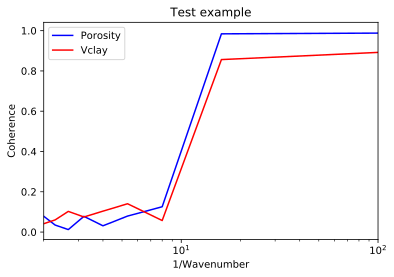

In [51]:
# Spectral coherence between true and predicted (test data)

sample_number = 12
Cxy_poro, wavenumber_poro = plt.cohere(Y_test[sample_number,0,:], test_output[sample_number,0,:], NFFT=16, Fs=1, color="blue")
Cxy_vclay, wavenumber_vclay = plt.cohere(Y_test[sample_number,1,:], test_output[sample_number,1,:], NFFT=16, Fs=1, color="red") 
# Cxy_sw, wavenumber_sw = plt.cohere(Y_test_petro[sample_number,2,:], test_output_petro[sample_number,2,:], NFFT=16, Fs=1, color="black")

# Adding epsilon to the first wavenumber value
wavenumber_poro[0] = wavenumber_poro[0] + 0.001
wavenumber_vclay[0] = wavenumber_vclay[0] + 0.001
# wavenumber_sw[0] = wavenumber_sw[0] + 0.001

plt.plot(1/wavenumber_poro, Cxy_poro, color="blue")
plt.plot(1/wavenumber_vclay, Cxy_vclay, color="red")
# plt.plot(1/wavenumber_sw, Cxy_sw, color="black")

plt.xlim(100,2)
plt.gca().invert_xaxis()
plt.xscale("log")

# plt.gca().legend(('Porosity','Vclay', 'Sw'))
plt.gca().legend(('Porosity','Vclay'))
plt.xlabel('1/Wavenumber')
plt.ylabel('Coherence')
plt.title('Test example')
plt.grid(b=False)

Text(0,0.5,'Depth')

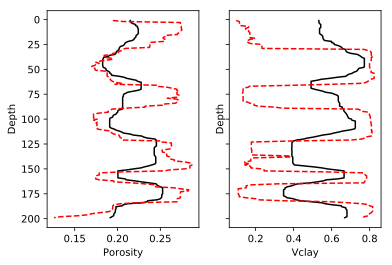

In [66]:
import scipy.signal as sp


# Checking training data (smoothed)

sample_number = 25
f, axarr = plt.subplots(1, 2, sharey = True)

ker_width = 15

axarr[0].plot(sp.medfilt(train_output[sample_number, 0, :],ker_width), depth, '-k')
axarr[0].plot(sp.medfilt(Y_train[sample_number, 0, :], ker_width), depth, '--r')
axarr[0].set_xlabel("Porosity")
axarr[0].set_ylabel("Depth")
axarr[0].invert_yaxis()
# axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(sp.medfilt(train_output[sample_number, 1, :], ker_width), depth, '-k')
axarr[1].plot(sp.medfilt(Y_train[sample_number, 1, :],ker_width), depth, '--r')
axarr[1].set_xlabel("Vclay")
axarr[1].set_ylabel("Depth")
# axarr[1].invert_yaxis()
# axarr[1].set_xlim(1,2)

In [67]:
por_corr_coeff_smooth_train = np.corrcoef(sp.medfilt(train_output[sample_number, 0, :],ker_width),
                                                     sp.medfilt(Y_train[sample_number, 0, :], ker_width))
                                          
vclay_corr_coeff_smooth_train = np.corrcoef(sp.medfilt(train_output[sample_number, 1, :],ker_width),
                                                     sp.medfilt(Y_train[sample_number, 1, :], ker_width))

print("Correlation coefficient between smoothed true and predicted porosity for training example = ", 
     '%.3f'%(por_corr_coeff_smooth_train[0,1]))
print("Correlation coefficient between smoothed true and predicted vclay for training example = ", 
     '%.3f'%(vclay_corr_coeff_smooth_train[0,1]))

Correlation coefficient between smoothed true and predicted porosity for training example =  0.734
Correlation coefficient between smoothed true and predicted vclay for training example =  0.665


Text(0,0.5,'Depth')

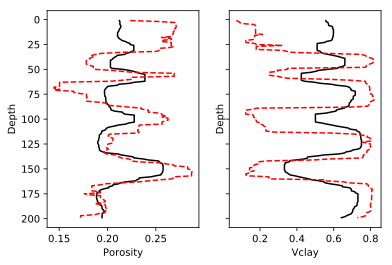

In [68]:
# Checking testing data (smoothed)

sample_number = 12
f, axarr = plt.subplots(1, 2, sharey = True)

ker_width = 15

axarr[0].plot(sp.medfilt(test_output[sample_number, 0, :],ker_width), depth, '-k')
axarr[0].plot(sp.medfilt(Y_test[sample_number, 0, :], ker_width), depth, '--r')
axarr[0].set_xlabel("Porosity")
axarr[0].set_ylabel("Depth")
axarr[0].invert_yaxis()
# axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(sp.medfilt(test_output[sample_number, 1, :],ker_width), depth, '-k')
axarr[1].plot(sp.medfilt(Y_test[sample_number, 1, :],ker_width), depth, '--r')
axarr[1].set_xlabel("Vclay")
axarr[1].set_ylabel("Depth")
# axarr[1].invert_yaxis()
# axarr[1].set_xlim(1,2)

In [69]:
por_corr_coeff_smooth_test = np.corrcoef(sp.medfilt(test_output[sample_number, 0, :],ker_width),
                                                     sp.medfilt(Y_test[sample_number, 0, :], ker_width))
                                          
vclay_corr_coeff_smooth_test = np.corrcoef(sp.medfilt(test_output[sample_number, 1, :],ker_width),
                                                     sp.medfilt(Y_test[sample_number, 1, :], ker_width))

print("Correlation coefficient between smoothed true and predicted porosity for test example = ", 
     '%.3f'%(por_corr_coeff_smooth_test[0,1]))
print("Correlation coefficient between smoothed true and predicted vclay for test example = ", 
     '%.3f'%(vclay_corr_coeff_smooth_test[0,1]))

Correlation coefficient between smoothed true and predicted porosity for test example =  0.666
Correlation coefficient between smoothed true and predicted vclay for test example =  0.663
